# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=bbd6504b74fe9aa72ae8cea147ec88e6142b6bdf1c99c06197943e13603f347f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=bc140a7c27c244c7d7cfe97154400d4cb9640ded8f9e59afdc5c6a57619a8b55
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## U-Net 网络

In [4]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = v2.Compose([     v2.Resize(size), 
                                             v2.RandomHorizontalFlip(),
                                             v2.RandomVerticalFlip(),
#                                              v2.RandomRotation(180) , 
                                             v2.ToImageTensor(), v2.ConvertImageDtype()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)
        orig_img = self.transform(orig_img)
        torch.manual_seed(seed)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


# 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 522: 


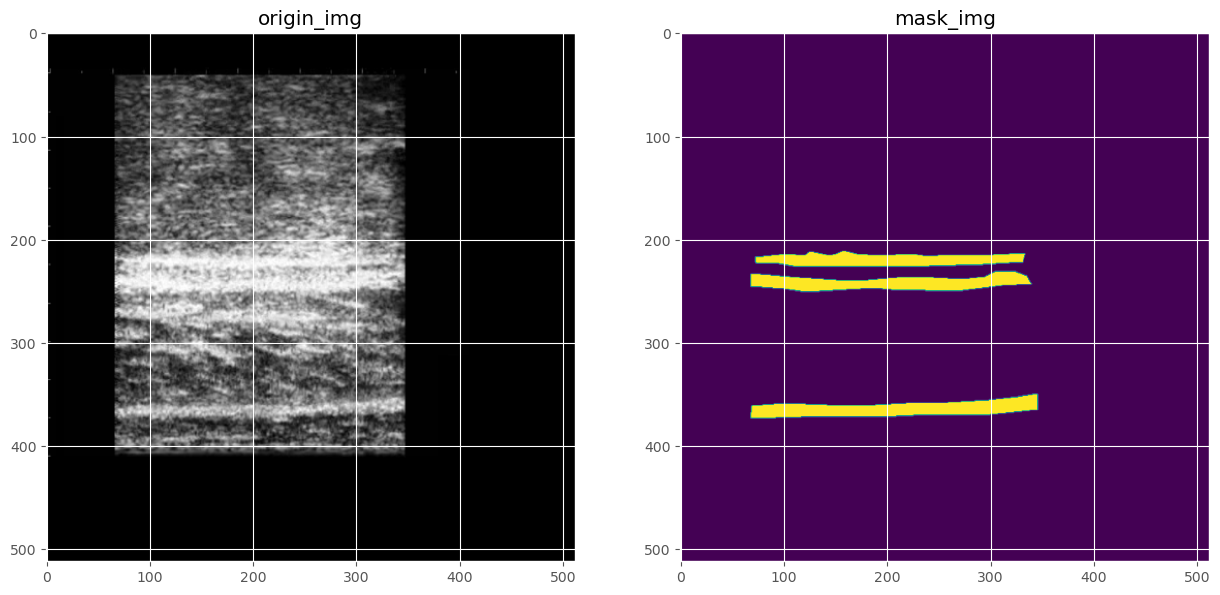

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = v2.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [9]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    print("Validation round")
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

## 设置wandb账号
用作统计与数据分析

In [10]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)

sigmoid = nn.Sigmoid()

def train(model, device, 
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    
    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        logging.info('Validation Dice score: {}'.format(val_score))
                        
                        predict = sigmoid(masks_pred[0])
                        predict = torch.where(predict>0.5,torch.ones_like(predict),torch.zeros_like(predict))

                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(predict.float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
                        
                        model.train()
                        scheduler.step(val_score)
    experiment.finish()

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数量为：{total_params}")
    print("其详情为：")
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    train(model, device)

    

Let's use 2 GPUs!
模型参数量为：31043521
其详情为：
module.down1.double_conv.double_conv.0.weight : torch.Size([64, 3, 3, 3])
module.down1.double_conv.double_conv.0.bias : torch.Size([64])
module.down1.double_conv.double_conv.1.weight : torch.Size([64])
module.down1.double_conv.double_conv.1.bias : torch.Size([64])
module.down1.double_conv.double_conv.3.weight : torch.Size([64, 64, 3, 3])
module.down1.double_conv.double_conv.3.bias : torch.Size([64])
module.down1.double_conv.double_conv.4.weight : torch.Size([64])
module.down1.double_conv.double_conv.4.bias : torch.Size([64])
module.down2.double_conv.double_conv.0.weight : torch.Size([128, 64, 3, 3])
module.down2.double_conv.double_conv.0.bias : torch.Size([128])
module.down2.double_conv.double_conv.1.weight : torch.Size([128])
module.down2.double_conv.double_conv.1.bias : torch.Size([128])
module.down2.double_conv.double_conv.3.weight : torch.Size([128, 128, 3, 3])
module.down2.double_conv.double_conv.3.bias : torch.Size([128])
module.down2.doubl

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240118_065620-tadoi5d6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vibrant-bee-21
wandb: ⭐️ View project at https://wandb.ai/cupes-wangtao/U-Net
wandb: 🚀 View run at https://wandb.ai/cupes-wangtao/U-Net/runs/tadoi5d6
Epoch 1/60:  20%|█▉        | 90/456 [00:16<00:59,  6.12img/s, loss (batch)=1.54]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 2.972806215286255, IoU Score 0.12016632407903671


Epoch 1/60:  39%|███▉      | 180/456 [00:46<00:45,  6.04img/s, loss (batch)=1.23]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 2.439115524291992, IoU Score 0.3673689067363739


Epoch 1/60:  59%|█████▉    | 270/456 [01:15<00:31,  5.91img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 2.0969181060791016, IoU Score 0.49578291177749634


Epoch 1/60:  79%|███████▉  | 360/456 [01:45<00:16,  5.83img/s, loss (batch)=1.06] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 2.0153567790985107, IoU Score 0.5223236680030823


Epoch 1/60:  99%|█████████▊| 450/456 [02:15<00:01,  5.41img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 2.0832533836364746, IoU Score 0.5228692293167114


Epoch 2/60:  18%|█▊        | 84/456 [00:14<01:03,  5.84img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.91798734664917, IoU Score 0.5635430216789246


Epoch 2/60:  38%|███▊      | 174/456 [00:44<00:48,  5.79img/s, loss (batch)=1.03] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.9164798259735107, IoU Score 0.5639597773551941


Epoch 2/60:  58%|█████▊    | 264/456 [01:14<00:33,  5.76img/s, loss (batch)=0.975]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.9096126556396484, IoU Score 0.5610461235046387


Epoch 2/60:  78%|███████▊  | 354/456 [01:45<00:17,  5.73img/s, loss (batch)=1.06] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.851584792137146, IoU Score 0.5076369643211365


Epoch 2/60:  97%|█████████▋| 444/456 [02:15<00:02,  5.78img/s, loss (batch)=1.09] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.8750877380371094, IoU Score 0.5321252346038818


Epoch 3/60:  17%|█▋        | 78/456 [00:13<01:05,  5.78img/s, loss (batch)=0.994]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 2.0418503284454346, IoU Score 0.4621596038341522


Epoch 3/60:  37%|███▋      | 168/456 [00:43<00:49,  5.78img/s, loss (batch)=0.952]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.7097632884979248, IoU Score 0.5858988165855408


Epoch 3/60:  57%|█████▋    | 258/456 [01:13<00:35,  5.64img/s, loss (batch)=1.05] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.799107551574707, IoU Score 0.5318311452865601


Epoch 3/60:  76%|███████▋  | 348/456 [01:43<00:18,  5.76img/s, loss (batch)=1.06] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.6991729736328125, IoU Score 0.561119794845581


Epoch 3/60:  96%|█████████▌| 438/456 [02:14<00:03,  5.79img/s, loss (batch)=0.924]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.6913648843765259, IoU Score 0.5806352496147156


Epoch 4/60:  16%|█▌        | 72/456 [00:12<01:07,  5.70img/s, loss (batch)=1.19]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.6588560342788696, IoU Score 0.5803802609443665


Epoch 4/60:  36%|███▌      | 162/456 [00:42<00:51,  5.66img/s, loss (batch)=0.941]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.677782654762268, IoU Score 0.5850209593772888


Epoch 4/60:  55%|█████▌    | 252/456 [01:13<00:35,  5.80img/s, loss (batch)=0.919]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.6565808057785034, IoU Score 0.5857169032096863


Epoch 4/60:  75%|███████▌  | 342/456 [01:43<00:19,  5.80img/s, loss (batch)=1]    

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.5936895608901978, IoU Score 0.5859386920928955


Epoch 4/60:  95%|█████████▍| 432/456 [02:13<00:04,  5.65img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.6196755170822144, IoU Score 0.6080653071403503


Epoch 5/60:  14%|█▍        | 66/456 [00:11<01:07,  5.81img/s, loss (batch)=0.838]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.5739880800247192, IoU Score 0.594149112701416


Epoch 5/60:  34%|███▍      | 156/456 [00:41<00:52,  5.73img/s, loss (batch)=0.91] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.6748512983322144, IoU Score 0.5493186116218567


Epoch 5/60:  54%|█████▍    | 246/456 [01:11<00:36,  5.78img/s, loss (batch)=0.984]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.5768296718597412, IoU Score 0.6075059771537781


Epoch 5/60:  74%|███████▎  | 336/456 [01:42<00:20,  5.81img/s, loss (batch)=0.885]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.7373042106628418, IoU Score 0.5031443238258362


Epoch 5/60:  93%|█████████▎| 426/456 [02:12<00:05,  5.77img/s, loss (batch)=0.936]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.5364092588424683, IoU Score 0.5367338061332703


Epoch 6/60:  13%|█▎        | 60/456 [00:10<01:08,  5.79img/s, loss (batch)=0.81] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.53872549533844, IoU Score 0.6115400195121765


Epoch 6/60:  33%|███▎      | 150/456 [00:40<00:54,  5.62img/s, loss (batch)=1.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.610284447669983, IoU Score 0.5728326439857483


Epoch 6/60:  53%|█████▎    | 240/456 [01:10<00:37,  5.71img/s, loss (batch)=0.957]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.4665311574935913, IoU Score 0.6073651313781738


Epoch 6/60:  72%|███████▏  | 330/456 [01:41<00:22,  5.68img/s, loss (batch)=0.819]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.4533864259719849, IoU Score 0.5842233896255493


Epoch 6/60:  92%|█████████▏| 420/456 [02:11<00:06,  5.70img/s, loss (batch)=0.9]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.5307453870773315, IoU Score 0.5793575048446655


Epoch 7/60:  12%|█▏        | 54/456 [00:09<01:10,  5.72img/s, loss (batch)=0.821]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.4259175062179565, IoU Score 0.5993267297744751


Epoch 7/60:  32%|███▏      | 144/456 [00:39<00:54,  5.69img/s, loss (batch)=0.881]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.4391146898269653, IoU Score 0.591152012348175


Epoch 7/60:  51%|█████▏    | 234/456 [01:10<00:39,  5.69img/s, loss (batch)=0.89] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.4724498987197876, IoU Score 0.581046462059021


Epoch 7/60:  71%|███████   | 324/456 [01:40<00:22,  5.81img/s, loss (batch)=0.682]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.4295480251312256, IoU Score 0.6079662442207336


Epoch 7/60:  91%|█████████ | 414/456 [02:10<00:07,  5.65img/s, loss (batch)=0.868]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.5316458940505981, IoU Score 0.565919816493988


Epoch 8/60:  11%|█         | 48/456 [00:08<01:11,  5.71img/s, loss (batch)=0.76]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.3691768646240234, IoU Score 0.5950103402137756


Epoch 8/60:  30%|███       | 138/456 [00:38<00:55,  5.76img/s, loss (batch)=0.828]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.491404414176941, IoU Score 0.5651264786720276


Epoch 8/60:  50%|█████     | 228/456 [01:09<00:40,  5.67img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.5162252187728882, IoU Score 0.5604921579360962


Epoch 8/60:  70%|██████▉   | 318/456 [01:39<00:24,  5.72img/s, loss (batch)=0.786]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.3456499576568604, IoU Score 0.5967987179756165


Epoch 8/60:  89%|████████▉ | 408/456 [02:09<00:08,  5.80img/s, loss (batch)=1]    

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 1.325984239578247, IoU Score 0.5956506729125977


Epoch 9/60:   9%|▉         | 42/456 [00:07<01:13,  5.67img/s, loss (batch)=0.884]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.376449704170227, IoU Score 0.6012448072433472


Epoch 9/60:  29%|██▉       | 132/456 [00:37<00:56,  5.73img/s, loss (batch)=0.787]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.3119131326675415, IoU Score 0.6020206809043884


Epoch 9/60:  49%|████▊     | 222/456 [01:07<00:41,  5.63img/s, loss (batch)=0.797]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.30166757106781, IoU Score 0.6062263250350952


Epoch 9/60:  68%|██████▊   | 312/456 [01:38<00:24,  5.78img/s, loss (batch)=0.729]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.4938064813613892, IoU Score 0.5244623422622681


Epoch 9/60:  88%|████████▊ | 402/456 [02:08<00:09,  5.67img/s, loss (batch)=0.692]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.3387880325317383, IoU Score 0.6084632873535156


Epoch 10/60:   8%|▊         | 36/456 [00:06<01:13,  5.70img/s, loss (batch)=0.902]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.3614873886108398, IoU Score 0.5911291837692261


Epoch 10/60:  28%|██▊       | 126/456 [00:36<00:58,  5.64img/s, loss (batch)=0.825]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.3401159048080444, IoU Score 0.6065191030502319


Epoch 10/60:  47%|████▋     | 216/456 [01:06<00:41,  5.83img/s, loss (batch)=0.733]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.314424753189087, IoU Score 0.5926510095596313


Epoch 10/60:  67%|██████▋   | 306/456 [01:36<00:26,  5.69img/s, loss (batch)=0.814]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.3052453994750977, IoU Score 0.6053861379623413


Epoch 10/60:  87%|████████▋ | 396/456 [02:07<00:10,  5.72img/s, loss (batch)=0.829]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.2933605909347534, IoU Score 0.6175179481506348


Epoch 11/60:   7%|▋         | 30/456 [00:05<01:14,  5.74img/s, loss (batch)=0.898]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.2918325662612915, IoU Score 0.6017635464668274


Epoch 11/60:  26%|██▋       | 120/456 [00:35<00:57,  5.82img/s, loss (batch)=0.73] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.2564500570297241, IoU Score 0.6156982183456421


Epoch 11/60:  46%|████▌     | 210/456 [01:05<00:42,  5.76img/s, loss (batch)=0.717]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.4902979135513306, IoU Score 0.5120850205421448


Epoch 11/60:  66%|██████▌   | 300/456 [01:36<00:27,  5.66img/s, loss (batch)=0.808]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.2421071529388428, IoU Score 0.6071586608886719


Epoch 11/60:  86%|████████▌ | 390/456 [02:06<00:11,  5.69img/s, loss (batch)=0.745]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.2613544464111328, IoU Score 0.6136630177497864


Epoch 12/60:   5%|▌         | 24/456 [00:04<01:14,  5.83img/s, loss (batch)=0.7]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.2340805530548096, IoU Score 0.6100121736526489


Epoch 12/60:  25%|██▌       | 114/456 [00:34<00:59,  5.72img/s, loss (batch)=0.909]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.2882270812988281, IoU Score 0.5969343781471252


Epoch 12/60:  45%|████▍     | 204/456 [01:04<00:43,  5.83img/s, loss (batch)=0.691]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.2132494449615479, IoU Score 0.6231973767280579


Epoch 12/60:  64%|██████▍   | 294/456 [01:35<00:28,  5.67img/s, loss (batch)=0.7]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.2330001592636108, IoU Score 0.6189578771591187


Epoch 12/60:  84%|████████▍ | 384/456 [02:05<00:12,  5.80img/s, loss (batch)=0.759]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.2276932001113892, IoU Score 0.6148442625999451


Epoch 13/60:   4%|▍         | 18/456 [00:03<01:16,  5.73img/s, loss (batch)=0.773]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.2699004411697388, IoU Score 0.5962235331535339


Epoch 13/60:  24%|██▎       | 108/456 [00:33<01:01,  5.70img/s, loss (batch)=0.765]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.2467141151428223, IoU Score 0.6059309840202332


Epoch 13/60:  43%|████▎     | 198/456 [01:03<00:45,  5.70img/s, loss (batch)=0.751]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.1921621561050415, IoU Score 0.6226124167442322


Epoch 13/60:  63%|██████▎   | 288/456 [01:33<00:29,  5.77img/s, loss (batch)=0.61] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.2839891910552979, IoU Score 0.5611572265625


Epoch 13/60:  83%|████████▎ | 378/456 [02:04<00:13,  5.68img/s, loss (batch)=0.928]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.1802278757095337, IoU Score 0.6219005584716797


Epoch 14/60:   3%|▎         | 12/456 [00:02<01:17,  5.72img/s, loss (batch)=1.04] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.2899291515350342, IoU Score 0.5584425330162048


Epoch 14/60:  22%|██▏       | 102/456 [00:32<01:02,  5.66img/s, loss (batch)=0.69] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.2255771160125732, IoU Score 0.60309898853302


Epoch 14/60:  42%|████▏     | 192/456 [01:02<00:46,  5.70img/s, loss (batch)=0.739]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 2.039729118347168, IoU Score 0.26627862453460693


Epoch 14/60:  62%|██████▏   | 282/456 [01:32<00:30,  5.75img/s, loss (batch)=0.653]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.235205054283142, IoU Score 0.5550490021705627


Epoch 14/60:  82%|████████▏ | 372/456 [02:03<00:14,  5.73img/s, loss (batch)=0.626]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.1367024183273315, IoU Score 0.6227700114250183


Epoch 15/60:   1%|▏         | 6/456 [00:01<01:18,  5.74img/s, loss (batch)=0.654]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.1844221353530884, IoU Score 0.5852636098861694


Epoch 15/60:  21%|██        | 96/456 [00:31<01:02,  5.80img/s, loss (batch)=0.653]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.2008066177368164, IoU Score 0.5888153910636902


Epoch 15/60:  41%|████      | 186/456 [01:01<00:48,  5.60img/s, loss (batch)=0.639]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.2831047773361206, IoU Score 0.531424343585968


Epoch 15/60:  61%|██████    | 276/456 [01:31<00:31,  5.64img/s, loss (batch)=0.97] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.4340192079544067, IoU Score 0.4456363916397095


Epoch 15/60:  80%|████████  | 366/456 [02:02<00:15,  5.66img/s, loss (batch)=0.746]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.3507187366485596, IoU Score 0.5012373924255371


Epoch 15/60: 100%|██████████| 456/456 [02:32<00:00,  5.75img/s, loss (batch)=0.7]  

Validation round


Epoch 15/60: 100%|██████████| 456/456 [02:47<00:00,  2.73img/s, loss (batch)=0.7]


Validation dice loss: 1.0843391418457031, IoU Score 0.6107050180435181


Epoch 16/60:  20%|█▉        | 90/456 [00:15<01:04,  5.70img/s, loss (batch)=0.726]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.1527845859527588, IoU Score 0.600023627281189


Epoch 16/60:  39%|███▉      | 180/456 [00:45<00:48,  5.74img/s, loss (batch)=0.658]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 1.123271107673645, IoU Score 0.6306852102279663


Epoch 16/60:  59%|█████▉    | 270/456 [01:16<00:33,  5.63img/s, loss (batch)=0.812]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.2761638164520264, IoU Score 0.5240744352340698


Epoch 16/60:  79%|███████▉  | 360/456 [01:46<00:16,  5.72img/s, loss (batch)=0.908]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.0734931230545044, IoU Score 0.6249158978462219


Epoch 16/60:  99%|█████████▊| 450/456 [02:16<00:01,  5.73img/s, loss (batch)=0.797]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.1876667737960815, IoU Score 0.5477664470672607


Epoch 17/60:  18%|█▊        | 84/456 [00:14<01:04,  5.77img/s, loss (batch)=0.678]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.3368396759033203, IoU Score 0.4826216399669647


Epoch 17/60:  38%|███▊      | 174/456 [00:44<00:48,  5.78img/s, loss (batch)=0.578]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.134076714515686, IoU Score 0.6114304661750793


Epoch 17/60:  58%|█████▊    | 264/456 [01:15<00:33,  5.80img/s, loss (batch)=0.524]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.0727661848068237, IoU Score 0.6243504285812378


Epoch 17/60:  78%|███████▊  | 354/456 [01:45<00:17,  5.72img/s, loss (batch)=0.762]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.0753693580627441, IoU Score 0.6176138520240784


Epoch 17/60:  97%|█████████▋| 444/456 [02:15<00:02,  5.77img/s, loss (batch)=0.551]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.0814526081085205, IoU Score 0.60621178150177


Epoch 18/60:  17%|█▋        | 78/456 [00:13<01:06,  5.66img/s, loss (batch)=0.704]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.079132080078125, IoU Score 0.6164182424545288


Epoch 18/60:  37%|███▋      | 168/456 [00:44<00:51,  5.61img/s, loss (batch)=0.538]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.1957348585128784, IoU Score 0.5436832904815674


Epoch 18/60:  57%|█████▋    | 258/456 [01:14<00:34,  5.72img/s, loss (batch)=0.616]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.2588133811950684, IoU Score 0.5144765377044678


Epoch 18/60:  76%|███████▋  | 348/456 [01:44<00:18,  5.74img/s, loss (batch)=0.573]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.1314277648925781, IoU Score 0.575837254524231


Epoch 18/60:  96%|█████████▌| 438/456 [02:14<00:03,  5.73img/s, loss (batch)=0.703]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.0719194412231445, IoU Score 0.6064140200614929


Epoch 19/60:  16%|█▌        | 72/456 [00:12<01:07,  5.68img/s, loss (batch)=0.668]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.0791031122207642, IoU Score 0.5970445275306702


Epoch 19/60:  36%|███▌      | 162/456 [00:42<00:50,  5.78img/s, loss (batch)=0.614]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.1761044263839722, IoU Score 0.5351330637931824


Epoch 19/60:  55%|█████▌    | 252/456 [01:12<00:35,  5.67img/s, loss (batch)=0.509]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.056179404258728, IoU Score 0.5984453558921814


Epoch 19/60:  75%|███████▌  | 342/456 [01:43<00:20,  5.64img/s, loss (batch)=0.761]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 1.0761280059814453, IoU Score 0.5902285575866699


Epoch 19/60:  95%|█████████▍| 432/456 [02:13<00:04,  5.83img/s, loss (batch)=0.481]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.010351300239563, IoU Score 0.6262855529785156


Epoch 20/60:  14%|█▍        | 66/456 [00:11<01:09,  5.61img/s, loss (batch)=0.774]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.0770779848098755, IoU Score 0.6008174419403076


Epoch 20/60:  34%|███▍      | 156/456 [00:42<00:53,  5.58img/s, loss (batch)=0.619]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.9903872609138489, IoU Score 0.6214137077331543


Epoch 20/60:  54%|█████▍    | 246/456 [01:12<00:37,  5.58img/s, loss (batch)=0.752]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.9523787498474121, IoU Score 0.6181646585464478


Epoch 20/60:  74%|███████▎  | 336/456 [01:42<00:21,  5.63img/s, loss (batch)=0.762]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.9450565576553345, IoU Score 0.5903110504150391


Epoch 20/60:  93%|█████████▎| 426/456 [02:12<00:05,  5.70img/s, loss (batch)=0.605]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.9188135266304016, IoU Score 0.6050736308097839


Epoch 21/60:  13%|█▎        | 60/456 [00:10<01:09,  5.70img/s, loss (batch)=0.599]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.8938636779785156, IoU Score 0.6226291060447693


Epoch 21/60:  33%|███▎      | 150/456 [00:40<00:54,  5.62img/s, loss (batch)=0.638]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 1.4927117824554443, IoU Score 0.3903031647205353


Epoch 21/60:  53%|█████▎    | 240/456 [01:11<00:37,  5.78img/s, loss (batch)=0.636]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.8904001712799072, IoU Score 0.6238539218902588


Epoch 21/60:  72%|███████▏  | 330/456 [01:41<00:21,  5.79img/s, loss (batch)=0.556]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.8877942562103271, IoU Score 0.6087102890014648


Epoch 21/60:  92%|█████████▏| 420/456 [02:11<00:06,  5.67img/s, loss (batch)=0.543]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.9745410084724426, IoU Score 0.5535032749176025


Epoch 22/60:  12%|█▏        | 54/456 [00:09<01:09,  5.78img/s, loss (batch)=0.475]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.8486447930335999, IoU Score 0.6041987538337708


Epoch 22/60:  32%|███▏      | 144/456 [00:39<00:53,  5.78img/s, loss (batch)=0.45] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.8097594380378723, IoU Score 0.620026707649231


Epoch 22/60:  51%|█████▏    | 234/456 [01:10<00:38,  5.78img/s, loss (batch)=0.483]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.8770496249198914, IoU Score 0.6054275035858154


Epoch 22/60:  71%|███████   | 324/456 [01:40<00:22,  5.75img/s, loss (batch)=0.469]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.5975840091705322, IoU Score 0.37536531686782837


Epoch 22/60:  91%|█████████ | 414/456 [02:10<00:07,  5.75img/s, loss (batch)=0.54] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.8145982623100281, IoU Score 0.6133562922477722


Epoch 23/60:  11%|█         | 48/456 [00:08<01:11,  5.73img/s, loss (batch)=0.464]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 1.0863659381866455, IoU Score 0.48328515887260437


Epoch 23/60:  30%|███       | 138/456 [00:38<00:54,  5.83img/s, loss (batch)=0.332]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.7864079475402832, IoU Score 0.6286427974700928


Epoch 23/60:  50%|█████     | 228/456 [01:09<00:39,  5.78img/s, loss (batch)=0.431]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.7794509530067444, IoU Score 0.6167840361595154


Epoch 23/60:  70%|██████▉   | 318/456 [01:39<00:23,  5.76img/s, loss (batch)=0.396]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.8133507966995239, IoU Score 0.6018073558807373


Epoch 23/60:  89%|████████▉ | 408/456 [02:10<00:08,  5.69img/s, loss (batch)=0.5]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.7988408207893372, IoU Score 0.5885164141654968


Epoch 24/60:   9%|▉         | 42/456 [00:07<01:13,  5.63img/s, loss (batch)=0.397]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.7561519145965576, IoU Score 0.6178199648857117


Epoch 24/60:  29%|██▉       | 132/456 [00:37<00:58,  5.57img/s, loss (batch)=0.393]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.7919031977653503, IoU Score 0.5989254117012024


Epoch 24/60:  49%|████▊     | 222/456 [01:08<00:40,  5.76img/s, loss (batch)=0.418]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.7402275800704956, IoU Score 0.6011634469032288


Epoch 24/60:  68%|██████▊   | 312/456 [01:38<00:25,  5.73img/s, loss (batch)=0.423]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.0401358604431152, IoU Score 0.44643089175224304


Epoch 24/60:  88%|████████▊ | 402/456 [02:08<00:09,  5.72img/s, loss (batch)=0.302]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.8456569314002991, IoU Score 0.5532684922218323


Epoch 25/60:   8%|▊         | 36/456 [00:06<01:12,  5.81img/s, loss (batch)=0.413]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.9144737124443054, IoU Score 0.5157402157783508


Epoch 25/60:  28%|██▊       | 126/456 [00:36<00:58,  5.67img/s, loss (batch)=0.379]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.9982894062995911, IoU Score 0.5211344957351685


Epoch 25/60:  47%|████▋     | 216/456 [01:06<00:42,  5.65img/s, loss (batch)=0.429]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.0112818479537964, IoU Score 0.46184420585632324


Epoch 25/60:  67%|██████▋   | 306/456 [01:37<00:25,  5.87img/s, loss (batch)=0.364]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.6833606958389282, IoU Score 0.6300798058509827


Epoch 25/60:  87%|████████▋ | 396/456 [02:07<00:10,  5.69img/s, loss (batch)=0.487]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.8065067529678345, IoU Score 0.553344190120697


Epoch 26/60:   7%|▋         | 30/456 [00:05<01:12,  5.84img/s, loss (batch)=0.32] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6751592755317688, IoU Score 0.6158251762390137


Epoch 26/60:  26%|██▋       | 120/456 [00:35<00:58,  5.76img/s, loss (batch)=0.626]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.6736893653869629, IoU Score 0.6027480363845825


Epoch 26/60:  46%|████▌     | 210/456 [01:05<00:42,  5.80img/s, loss (batch)=0.29] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.9654443860054016, IoU Score 0.49059826135635376


Epoch 26/60:  66%|██████▌   | 300/456 [01:36<00:27,  5.75img/s, loss (batch)=0.258]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.6695654392242432, IoU Score 0.5993859171867371


Epoch 26/60:  86%|████████▌ | 390/456 [02:06<00:11,  5.74img/s, loss (batch)=0.474]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6472564339637756, IoU Score 0.6003336906433105


Epoch 27/60:   5%|▌         | 24/456 [00:04<01:15,  5.74img/s, loss (batch)=0.764]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.6221654415130615, IoU Score 0.6158952116966248


Epoch 27/60:  25%|██▌       | 114/456 [00:34<01:03,  5.38img/s, loss (batch)=0.733]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.731540858745575, IoU Score 0.5628393888473511


Epoch 27/60:  45%|████▍     | 204/456 [01:04<00:43,  5.80img/s, loss (batch)=0.34] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.6917267441749573, IoU Score 0.5969657897949219


Epoch 27/60:  64%|██████▍   | 294/456 [01:35<00:28,  5.65img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.7212960124015808, IoU Score 0.5886335968971252


Epoch 27/60:  84%|████████▍ | 384/456 [02:05<00:12,  5.70img/s, loss (batch)=0.29] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.719266951084137, IoU Score 0.5784975290298462


Epoch 28/60:   4%|▍         | 18/456 [00:03<01:16,  5.75img/s, loss (batch)=0.33] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.7692804932594299, IoU Score 0.5385022163391113


Epoch 28/60:  24%|██▎       | 108/456 [00:33<00:59,  5.81img/s, loss (batch)=0.323]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.8037260174751282, IoU Score 0.5164000391960144


Epoch 28/60:  43%|████▎     | 198/456 [01:03<00:44,  5.74img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.8175496459007263, IoU Score 0.49819108843803406


Epoch 28/60:  63%|██████▎   | 288/456 [01:34<00:29,  5.70img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.6278974413871765, IoU Score 0.617461621761322


Epoch 28/60:  83%|████████▎ | 378/456 [02:04<00:13,  5.66img/s, loss (batch)=0.306]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5943642854690552, IoU Score 0.6373358964920044


Epoch 29/60:   3%|▎         | 12/456 [00:02<01:16,  5.77img/s, loss (batch)=0.301]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.6472843885421753, IoU Score 0.6016626954078674


Epoch 29/60:  22%|██▏       | 102/456 [00:32<01:01,  5.77img/s, loss (batch)=0.277]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5703415274620056, IoU Score 0.6361355185508728


Epoch 29/60:  42%|████▏     | 192/456 [01:02<00:45,  5.78img/s, loss (batch)=0.571]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5524390339851379, IoU Score 0.6440460681915283


Epoch 29/60:  62%|██████▏   | 282/456 [01:33<00:30,  5.66img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6240037083625793, IoU Score 0.6177882552146912


Epoch 29/60:  82%|████████▏ | 372/456 [02:03<00:14,  5.67img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.561478853225708, IoU Score 0.6337313652038574


Epoch 30/60:   1%|▏         | 6/456 [00:01<01:16,  5.88img/s, loss (batch)=0.345]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5539981722831726, IoU Score 0.6277275681495667


Epoch 30/60:  21%|██        | 96/456 [00:31<01:04,  5.61img/s, loss (batch)=0.259]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.8274945020675659, IoU Score 0.5066425800323486


Epoch 30/60:  41%|████      | 186/456 [01:01<00:47,  5.73img/s, loss (batch)=0.283]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.5888866186141968, IoU Score 0.6209993958473206


Epoch 30/60:  61%|██████    | 276/456 [01:32<00:31,  5.74img/s, loss (batch)=0.271]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.644668459892273, IoU Score 0.5843202471733093


Epoch 30/60:  80%|████████  | 366/456 [02:02<00:15,  5.77img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5888152718544006, IoU Score 0.6037600636482239


Epoch 30/60: 100%|██████████| 456/456 [02:32<00:00,  5.78img/s, loss (batch)=0.39] 

Validation round


Epoch 30/60: 100%|██████████| 456/456 [02:47<00:00,  2.73img/s, loss (batch)=0.39]


Validation dice loss: 0.5880917310714722, IoU Score 0.6316025257110596


Epoch 31/60:  20%|█▉        | 90/456 [00:15<01:03,  5.77img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.5667003989219666, IoU Score 0.6295543909072876


Epoch 31/60:  39%|███▉      | 180/456 [00:46<00:47,  5.79img/s, loss (batch)=0.368]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.127238392829895, IoU Score 0.3850070536136627


Epoch 31/60:  59%|█████▉    | 270/456 [01:16<00:32,  5.77img/s, loss (batch)=0.254]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5693408250808716, IoU Score 0.6300123333930969


Epoch 31/60:  79%|███████▉  | 360/456 [01:46<00:16,  5.84img/s, loss (batch)=0.703]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5401557087898254, IoU Score 0.6365206837654114


Epoch 31/60:  99%|█████████▊| 450/456 [02:17<00:01,  5.76img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5986114144325256, IoU Score 0.6076235771179199


Epoch 32/60:  18%|█▊        | 84/456 [00:14<01:05,  5.69img/s, loss (batch)=0.332]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.6606049537658691, IoU Score 0.5703374743461609


Epoch 32/60:  38%|███▊      | 174/456 [00:45<00:52,  5.33img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6207290291786194, IoU Score 0.5882312655448914


Epoch 32/60:  58%|█████▊    | 264/456 [01:15<00:33,  5.69img/s, loss (batch)=0.646]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.7189992070198059, IoU Score 0.5555951595306396


Epoch 32/60:  78%|███████▊  | 354/456 [01:45<00:18,  5.57img/s, loss (batch)=0.829]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.6033209562301636, IoU Score 0.3589702546596527


Epoch 32/60:  97%|█████████▋| 444/456 [02:16<00:02,  5.63img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.5655876994132996, IoU Score 0.623740017414093


Epoch 33/60:  17%|█▋        | 78/456 [00:13<01:05,  5.75img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5496546626091003, IoU Score 0.6350106596946716


Epoch 33/60:  37%|███▋      | 168/456 [00:43<00:50,  5.75img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5407730340957642, IoU Score 0.6444512605667114


Epoch 33/60:  57%|█████▋    | 258/456 [01:14<00:34,  5.77img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.6894564032554626, IoU Score 0.5454034805297852


Epoch 33/60:  76%|███████▋  | 348/456 [01:44<00:18,  5.81img/s, loss (batch)=0.245]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5738975405693054, IoU Score 0.5922026634216309


Epoch 33/60:  96%|█████████▌| 438/456 [02:14<00:03,  5.67img/s, loss (batch)=0.265]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.6206967234611511, IoU Score 0.5890417098999023


Epoch 34/60:  16%|█▌        | 72/456 [00:12<01:06,  5.78img/s, loss (batch)=0.238]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.639068067073822, IoU Score 0.5712947845458984


Epoch 34/60:  36%|███▌      | 162/456 [00:42<00:51,  5.66img/s, loss (batch)=0.648]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6228145360946655, IoU Score 0.5708075165748596


Epoch 34/60:  55%|█████▌    | 252/456 [01:13<00:35,  5.74img/s, loss (batch)=0.327]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5700216293334961, IoU Score 0.604516327381134


Epoch 34/60:  75%|███████▌  | 342/456 [01:43<00:20,  5.67img/s, loss (batch)=0.852]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.6668460965156555, IoU Score 0.5560170412063599


Epoch 34/60:  95%|█████████▍| 432/456 [02:13<00:04,  5.63img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 1.9634455442428589, IoU Score 0.27570462226867676


Epoch 35/60:  14%|█▍        | 66/456 [00:11<01:08,  5.73img/s, loss (batch)=0.377]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.6135378479957581, IoU Score 0.5881549119949341


Epoch 35/60:  34%|███▍      | 156/456 [00:42<01:00,  4.92img/s, loss (batch)=0.2] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.550324022769928, IoU Score 0.6376472115516663


Epoch 35/60:  54%|█████▍    | 246/456 [01:12<00:36,  5.73img/s, loss (batch)=0.242]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.8260114789009094, IoU Score 0.48754581809043884


Epoch 35/60:  74%|███████▎  | 336/456 [01:42<00:20,  5.78img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5026383399963379, IoU Score 0.6407007575035095


Epoch 35/60:  93%|█████████▎| 426/456 [02:13<00:05,  5.85img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.8487346768379211, IoU Score 0.4892585575580597


Epoch 36/60:  13%|█▎        | 60/456 [00:10<01:10,  5.62img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5508216619491577, IoU Score 0.615666389465332


Epoch 36/60:  33%|███▎      | 150/456 [00:40<00:54,  5.64img/s, loss (batch)=0.283]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.6218299269676208, IoU Score 0.5741400122642517


Epoch 36/60:  53%|█████▎    | 240/456 [01:11<00:37,  5.73img/s, loss (batch)=0.408]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5356438159942627, IoU Score 0.6336660981178284


Epoch 36/60:  72%|███████▏  | 330/456 [01:41<00:22,  5.72img/s, loss (batch)=0.428]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5697115063667297, IoU Score 0.6147711873054504


Epoch 36/60:  92%|█████████▏| 420/456 [02:11<00:06,  5.77img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5147762298583984, IoU Score 0.6452552080154419


Epoch 37/60:  12%|█▏        | 54/456 [00:09<01:10,  5.71img/s, loss (batch)=0.241]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5929640531539917, IoU Score 0.571770191192627


Epoch 37/60:  32%|███▏      | 144/456 [00:39<00:54,  5.76img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5165829658508301, IoU Score 0.6436724066734314


Epoch 37/60:  51%|█████▏    | 234/456 [01:10<00:38,  5.70img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.0290875434875488, IoU Score 0.4320303797721863


Epoch 37/60:  71%|███████   | 324/456 [01:40<00:22,  5.76img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.575356125831604, IoU Score 0.5886178016662598


Epoch 37/60:  91%|█████████ | 414/456 [02:10<00:07,  5.74img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.9780876040458679, IoU Score 0.4496139585971832


Epoch 38/60:  11%|█         | 48/456 [00:08<01:09,  5.85img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.507077157497406, IoU Score 0.6233747005462646


Epoch 38/60:  30%|███       | 138/456 [00:38<00:55,  5.71img/s, loss (batch)=0.126]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5695871114730835, IoU Score 0.6271430253982544


Epoch 38/60:  50%|█████     | 228/456 [01:08<00:39,  5.75img/s, loss (batch)=0.394]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5224353075027466, IoU Score 0.6384249329566956


Epoch 38/60:  70%|██████▉   | 318/456 [01:39<00:24,  5.66img/s, loss (batch)=0.374]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.151617407798767, IoU Score 0.41669246554374695


Epoch 38/60:  89%|████████▉ | 408/456 [02:09<00:08,  5.72img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.5455248355865479, IoU Score 0.6122820377349854


Epoch 39/60:   9%|▉         | 42/456 [00:07<01:12,  5.70img/s, loss (batch)=0.246]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5777184367179871, IoU Score 0.582892656326294


Epoch 39/60:  29%|██▉       | 132/456 [00:37<00:57,  5.63img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.539376437664032, IoU Score 0.6145440340042114


Epoch 39/60:  49%|████▊     | 222/456 [01:08<00:41,  5.64img/s, loss (batch)=0.713]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5170724987983704, IoU Score 0.619742751121521


Epoch 39/60:  68%|██████▊   | 312/456 [01:38<00:24,  5.78img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.48160240054130554, IoU Score 0.6353468894958496


Epoch 39/60:  88%|████████▊ | 402/456 [02:08<00:09,  5.84img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.521789014339447, IoU Score 0.640602707862854


Epoch 40/60:   8%|▊         | 36/456 [00:06<01:13,  5.71img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.53538978099823, IoU Score 0.6083320379257202


Epoch 40/60:  28%|██▊       | 126/456 [00:36<00:58,  5.68img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5451166033744812, IoU Score 0.5799434185028076


Epoch 40/60:  47%|████▋     | 216/456 [01:06<00:41,  5.79img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5217993855476379, IoU Score 0.6269834637641907


Epoch 40/60:  67%|██████▋   | 306/456 [01:37<00:26,  5.76img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5108299851417542, IoU Score 0.6342732906341553


Epoch 40/60:  87%|████████▋ | 396/456 [02:08<00:10,  5.73img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.809298574924469, IoU Score 0.49271994829177856


Epoch 41/60:   7%|▋         | 30/456 [00:05<01:15,  5.62img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.6808509826660156, IoU Score 0.3365325331687927


Epoch 41/60:  26%|██▋       | 120/456 [00:35<01:00,  5.58img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.5865511298179626, IoU Score 0.5828207731246948


Epoch 41/60:  46%|████▌     | 210/456 [01:06<00:42,  5.76img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.6221176385879517, IoU Score 0.5533620715141296


Epoch 41/60:  66%|██████▌   | 300/456 [01:36<00:27,  5.66img/s, loss (batch)=0.272]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.478176474571228, IoU Score 0.6326499581336975


Epoch 41/60:  86%|████████▌ | 390/456 [02:06<00:11,  5.82img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5952348113059998, IoU Score 0.5934995412826538


Epoch 42/60:   5%|▌         | 24/456 [00:04<01:14,  5.82img/s, loss (batch)=0.39] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.5393115878105164, IoU Score 0.6205407977104187


Epoch 42/60:  25%|██▌       | 114/456 [00:34<00:59,  5.72img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5339641571044922, IoU Score 0.6184899806976318


Epoch 42/60:  45%|████▍     | 204/456 [01:04<00:43,  5.83img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4809100031852722, IoU Score 0.6316725015640259


Epoch 42/60:  64%|██████▍   | 294/456 [01:35<00:28,  5.73img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5647690892219543, IoU Score 0.5809409022331238


Epoch 42/60:  84%|████████▍ | 384/456 [02:05<00:12,  5.70img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.6658312082290649, IoU Score 0.5480475425720215


Epoch 43/60:   4%|▍         | 18/456 [00:03<01:15,  5.79img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.5566504597663879, IoU Score 0.6191508769989014


Epoch 43/60:  24%|██▎       | 108/456 [00:33<01:01,  5.67img/s, loss (batch)=0.265]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.4553890526294708, IoU Score 0.644963800907135


Epoch 43/60:  43%|████▎     | 198/456 [01:03<00:44,  5.74img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5668988823890686, IoU Score 0.6219074130058289


Epoch 43/60:  63%|██████▎   | 288/456 [01:34<00:29,  5.79img/s, loss (batch)=0.29] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.5733945965766907, IoU Score 0.6111373901367188


Epoch 43/60:  83%|████████▎ | 378/456 [02:04<00:13,  5.71img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.5321411490440369, IoU Score 0.6209090352058411


Epoch 44/60:   3%|▎         | 12/456 [00:02<01:16,  5.79img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.532439112663269, IoU Score 0.6272880434989929


Epoch 44/60:  22%|██▏       | 102/456 [00:32<01:01,  5.76img/s, loss (batch)=0.548]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 1.0890061855316162, IoU Score 0.4127214550971985


Epoch 44/60:  42%|████▏     | 192/456 [01:02<00:46,  5.70img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.6220348477363586, IoU Score 0.5593599081039429


Epoch 44/60:  62%|██████▏   | 282/456 [01:33<00:30,  5.71img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.0003583431243896, IoU Score 0.4397072494029999


Epoch 44/60:  82%|████████▏ | 372/456 [02:03<00:14,  5.66img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5658947825431824, IoU Score 0.5803765058517456


Epoch 45/60:   1%|▏         | 6/456 [00:01<01:17,  5.83img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5962575078010559, IoU Score 0.5853529572486877


Epoch 45/60:  21%|██        | 96/456 [00:31<01:03,  5.70img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.6703757047653198, IoU Score 0.5650037527084351


Epoch 45/60:  41%|████      | 186/456 [01:01<00:47,  5.74img/s, loss (batch)=0.282]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.6085900664329529, IoU Score 0.5679810643196106


Epoch 45/60:  61%|██████    | 276/456 [01:31<00:31,  5.75img/s, loss (batch)=0.263]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.7241297960281372, IoU Score 0.5021572113037109


Epoch 45/60:  80%|████████  | 366/456 [02:02<00:15,  5.73img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5636301636695862, IoU Score 0.6122481822967529


Epoch 45/60: 100%|██████████| 456/456 [02:32<00:00,  5.75img/s, loss (batch)=0.401]

Validation round


Epoch 45/60: 100%|██████████| 456/456 [02:47<00:00,  2.73img/s, loss (batch)=0.401]


Validation dice loss: 0.6980260610580444, IoU Score 0.5102248787879944


Epoch 46/60:  20%|█▉        | 90/456 [00:15<01:03,  5.80img/s, loss (batch)=0.274]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.053170084953308, IoU Score 0.4050578773021698


Epoch 46/60:  39%|███▉      | 180/456 [00:46<00:48,  5.70img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.58batch/s]


Validation dice loss: 0.5137763023376465, IoU Score 0.6212300658226013


Epoch 46/60:  59%|█████▉    | 270/456 [01:16<00:32,  5.75img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5515210628509521, IoU Score 0.6138890981674194


Epoch 46/60:  79%|███████▉  | 360/456 [01:47<00:16,  5.66img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 1.5212403535842896, IoU Score 0.35315024852752686


Epoch 46/60:  99%|█████████▊| 450/456 [02:17<00:01,  5.72img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.9608497619628906, IoU Score 0.4784453511238098


Epoch 47/60:  18%|█▊        | 84/456 [00:14<01:04,  5.80img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.8928559422492981, IoU Score 0.492323637008667


Epoch 47/60:  38%|███▊      | 174/456 [00:45<00:49,  5.75img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.6280950903892517, IoU Score 0.5615653991699219


Epoch 47/60:  58%|█████▊    | 264/456 [01:15<00:33,  5.74img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.4908037781715393, IoU Score 0.6414111256599426


Epoch 47/60:  78%|███████▊  | 354/456 [01:45<00:18,  5.66img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5073786973953247, IoU Score 0.6494473218917847


Epoch 47/60:  97%|█████████▋| 444/456 [02:16<00:02,  5.66img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5500345826148987, IoU Score 0.6145915985107422


Epoch 48/60:  17%|█▋        | 78/456 [00:13<01:06,  5.72img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.538203775882721, IoU Score 0.624946117401123


Epoch 48/60:  37%|███▋      | 168/456 [00:43<00:50,  5.65img/s, loss (batch)=0.226]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.8256620764732361, IoU Score 0.4897327125072479


Epoch 48/60:  57%|█████▋    | 258/456 [01:14<00:35,  5.63img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.6727114319801331, IoU Score 0.5434348583221436


Epoch 48/60:  76%|███████▋  | 348/456 [01:44<00:18,  5.70img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5984001755714417, IoU Score 0.5801342129707336


Epoch 48/60:  96%|█████████▌| 438/456 [02:14<00:03,  5.66img/s, loss (batch)=0.78] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 0.768897533416748, IoU Score 0.5020098686218262


Epoch 49/60:  16%|█▌        | 72/456 [00:12<01:07,  5.73img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5900768637657166, IoU Score 0.5923109650611877


Epoch 49/60:  36%|███▌      | 162/456 [00:42<00:49,  5.88img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5431396961212158, IoU Score 0.6169244647026062


Epoch 49/60:  55%|█████▌    | 252/456 [01:13<00:35,  5.72img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5305405259132385, IoU Score 0.6109744310379028


Epoch 49/60:  75%|███████▌  | 342/456 [01:43<00:19,  5.74img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5166917443275452, IoU Score 0.6097078919410706


Epoch 49/60:  95%|█████████▍| 432/456 [02:14<00:04,  5.57img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5378340482711792, IoU Score 0.633046567440033


Epoch 50/60:  14%|█▍        | 66/456 [00:11<01:08,  5.71img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation dice loss: 0.5229079723358154, IoU Score 0.6393620371818542


Epoch 50/60:  34%|███▍      | 156/456 [00:42<00:52,  5.73img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.54batch/s]


Validation dice loss: 0.5863732695579529, IoU Score 0.5947235226631165


Epoch 50/60:  54%|█████▍    | 246/456 [01:12<00:36,  5.82img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.59batch/s]


Validation dice loss: 0.5521378517150879, IoU Score 0.5992165803909302


Epoch 50/60:  74%|███████▎  | 336/456 [01:43<00:20,  5.77img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.4832078814506531, IoU Score 0.6336237192153931


Epoch 50/60:  93%|█████████▎| 426/456 [02:13<00:05,  5.79img/s, loss (batch)=0.126]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5561913847923279, IoU Score 0.5942530035972595


Epoch 51/60:  13%|█▎        | 60/456 [00:10<01:09,  5.71img/s, loss (batch)=0.315]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.509615957736969, IoU Score 0.6307534575462341


Epoch 51/60:  33%|███▎      | 150/456 [00:40<00:54,  5.67img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.7082206606864929, IoU Score 0.5204153060913086


Epoch 51/60:  53%|█████▎    | 240/456 [01:11<00:38,  5.67img/s, loss (batch)=0.34] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.8171584606170654, IoU Score 0.4828921854496002


Epoch 51/60:  72%|███████▏  | 330/456 [01:41<00:22,  5.73img/s, loss (batch)=0.305]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.59batch/s]


Validation dice loss: 0.540361225605011, IoU Score 0.6157433390617371


Epoch 51/60:  92%|█████████▏| 420/456 [02:12<00:06,  5.74img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.7468230128288269, IoU Score 0.49284738302230835


Epoch 52/60:  12%|█▏        | 54/456 [00:09<01:10,  5.67img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 0.8692437410354614, IoU Score 0.4658203721046448


Epoch 52/60:  32%|███▏      | 144/456 [00:40<00:55,  5.61img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.7095412015914917, IoU Score 0.5166309475898743


Epoch 52/60:  51%|█████▏    | 234/456 [01:10<00:39,  5.65img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 2.1155073642730713, IoU Score 0.332292765378952


Epoch 52/60:  71%|███████   | 324/456 [01:41<00:22,  5.82img/s, loss (batch)=0.601]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.553138017654419, IoU Score 0.6146788001060486


Epoch 52/60:  91%|█████████ | 414/456 [02:11<00:07,  5.77img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.4903523325920105, IoU Score 0.6208023428916931


Epoch 53/60:  11%|█         | 48/456 [00:08<01:12,  5.63img/s, loss (batch)=0.244]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.6668611764907837, IoU Score 0.5239667892456055


Epoch 53/60:  30%|███       | 138/456 [00:38<00:55,  5.76img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.5921845436096191, IoU Score 0.5809759497642517


Epoch 53/60:  50%|█████     | 228/456 [01:09<00:40,  5.67img/s, loss (batch)=0.395]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.6934785842895508, IoU Score 0.5072711110115051


Epoch 53/60:  70%|██████▉   | 318/456 [01:39<00:23,  5.77img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.7295257449150085, IoU Score 0.5277279019355774


Epoch 53/60:  89%|████████▉ | 408/456 [02:09<00:08,  5.81img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.5865108966827393, IoU Score 0.5773819088935852


Epoch 54/60:   9%|▉         | 42/456 [00:07<01:10,  5.89img/s, loss (batch)=0.714]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 0.5554713010787964, IoU Score 0.6297662258148193


Epoch 54/60:  29%|██▉       | 132/456 [00:37<00:57,  5.65img/s, loss (batch)=0.145]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.5887759923934937, IoU Score 0.5925653576850891


Epoch 54/60:  49%|████▊     | 222/456 [01:08<00:40,  5.73img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.1864529848098755, IoU Score 0.4024888873100281


Epoch 54/60:  68%|██████▊   | 312/456 [01:38<00:25,  5.70img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.48285263776779175, IoU Score 0.6151965856552124


Epoch 54/60:  88%|████████▊ | 402/456 [02:08<00:09,  5.75img/s, loss (batch)=0.612]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.8788710236549377, IoU Score 0.4660232961177826


Epoch 55/60:   8%|▊         | 36/456 [00:06<01:13,  5.71img/s, loss (batch)=0.261]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.8379809856414795, IoU Score 0.4861840307712555


Epoch 55/60:  28%|██▊       | 126/456 [00:36<00:57,  5.71img/s, loss (batch)=0.357]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5030699968338013, IoU Score 0.6248067021369934


Epoch 55/60:  47%|████▋     | 216/456 [01:06<00:41,  5.80img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.6450737714767456, IoU Score 0.5344424843788147


Epoch 55/60:  67%|██████▋   | 306/456 [01:36<00:26,  5.71img/s, loss (batch)=0.201]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.767987847328186, IoU Score 0.46155479550361633


Epoch 55/60:  87%|████████▋ | 396/456 [02:07<00:10,  5.66img/s, loss (batch)=0.477]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.0342655181884766, IoU Score 0.42948660254478455


Epoch 56/60:   7%|▋         | 30/456 [00:05<01:20,  5.30img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.7633016705513, IoU Score 0.49073582887649536


Epoch 56/60:  26%|██▋       | 120/456 [00:35<00:58,  5.73img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.6023167371749878, IoU Score 0.5779824256896973


Epoch 56/60:  46%|████▌     | 210/456 [01:05<00:43,  5.72img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 0.5086092948913574, IoU Score 0.6207485198974609


Epoch 56/60:  66%|██████▌   | 300/456 [01:36<00:31,  4.96img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5769676566123962, IoU Score 0.5796523690223694


Epoch 56/60:  86%|████████▌ | 390/456 [02:06<00:11,  5.69img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.8622602820396423, IoU Score 0.4508063495159149


Epoch 57/60:   5%|▌         | 24/456 [00:04<01:17,  5.60img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 2.3163230419158936, IoU Score 0.29006892442703247


Epoch 57/60:  25%|██▌       | 114/456 [00:34<00:59,  5.74img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.589220643043518, IoU Score 0.34941366314888


Epoch 57/60:  45%|████▍     | 204/456 [01:04<00:44,  5.64img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.8279204964637756, IoU Score 0.4890911281108856


Epoch 57/60:  64%|██████▍   | 294/456 [01:35<00:28,  5.65img/s, loss (batch)=0.288]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.6976428627967834, IoU Score 0.5343822836875916


Epoch 57/60:  84%|████████▍ | 384/456 [02:05<00:12,  5.81img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 0.49358347058296204, IoU Score 0.632853090763092


Epoch 58/60:   4%|▍         | 18/456 [00:03<01:16,  5.75img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5390954613685608, IoU Score 0.6069918870925903


Epoch 58/60:  24%|██▎       | 108/456 [00:33<00:59,  5.88img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.5825395584106445, IoU Score 0.55635666847229


Epoch 58/60:  43%|████▎     | 198/456 [01:03<00:44,  5.75img/s, loss (batch)=0.13] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.8391323089599609, IoU Score 0.46152299642562866


Epoch 58/60:  63%|██████▎   | 288/456 [01:34<00:29,  5.76img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5211719274520874, IoU Score 0.6400869488716125


Epoch 58/60:  83%|████████▎ | 378/456 [02:04<00:14,  5.56img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5615452527999878, IoU Score 0.6035618782043457


Epoch 59/60:   3%|▎         | 12/456 [00:02<01:16,  5.80img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 0.9957537055015564, IoU Score 0.4323369264602661


Epoch 59/60:  22%|██▏       | 102/456 [00:32<01:02,  5.66img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.6215267181396484, IoU Score 0.5944352746009827


Epoch 59/60:  42%|████▏     | 192/456 [01:03<00:46,  5.66img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.2192960977554321, IoU Score 0.3935208320617676


Epoch 59/60:  62%|██████▏   | 282/456 [01:33<00:30,  5.75img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.8456597924232483, IoU Score 0.46859225630760193


Epoch 59/60:  82%|████████▏ | 372/456 [02:03<00:14,  5.73img/s, loss (batch)=0.12]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6791952848434448, IoU Score 0.5419598817825317


Epoch 60/60:   1%|▏         | 6/456 [00:01<01:18,  5.70img/s, loss (batch)=0.785]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5452250242233276, IoU Score 0.5942332148551941


Epoch 60/60:  21%|██        | 96/456 [00:31<01:03,  5.71img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.4949009418487549, IoU Score 0.6323434114456177


Epoch 60/60:  41%|████      | 186/456 [01:01<00:46,  5.82img/s, loss (batch)=0.316]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.5075274109840393, IoU Score 0.6169608235359192


Epoch 60/60:  61%|██████    | 276/456 [01:31<00:31,  5.74img/s, loss (batch)=0.286]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.500678300857544, IoU Score 0.6174548268318176


Epoch 60/60:  80%|████████  | 366/456 [02:01<00:15,  5.73img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.4940253794193268, IoU Score 0.6208541989326477


Epoch 60/60: 100%|██████████| 456/456 [02:31<00:00,  5.79img/s, loss (batch)=0.12]  

Validation round


Epoch 60/60: 100%|██████████| 456/456 [02:46<00:00,  2.74img/s, loss (batch)=0.12]
wandb: Waiting for W&B process to finish... (success).


Validation dice loss: 0.504370391368866, IoU Score 0.6256518363952637


wandb: 
wandb: Run history:
wandb:                epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:        learning rate ▅▄▃▂▂▁▁▁▁▁▁▁▁▂█▇█▆▇▅▅▅▆▆█▅▃▆▅▆▅▅▅▇▄▁▇▇▆▄
wandb:                 step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:            train iou ▄▅▅▇▅▇█▃▅▁▇▆▇▆▅▇▇▇█▇▇▂▃▇▇█▆▇█▆▇▇█▇▇▇█▃█▆
wandb:           train loss █▇▆▅▇▅▅▆▆▇▅▄▄▄▄▃▃▂▂▂▂▅▄▂▂▁▂▂▁▂▁▁▁▁▁▁▁▄▁▂
wandb:      validation Dice ██▆▇▅▅▅▄▅▄▄▄▃▃▂▂▃▂▂▃▁▁█▁▁▁▁▁▁▂▆▃▁▃▂▁▂▁▄▁
wandb: validation IoU Score ▆▆▇▅▇▇▇▇▆▇█▆███▇▅▇▇▅██▁███▇█▇▆▂▅█▅▆▇▇█▃█
wandb: 
wandb: Run summary:
wandb:                epoch 60
wandb:        learning rate 3e-05
wandb:                 step 13680
wandb:            train iou 0.82899
wandb:           train loss 0.12014
wandb:      validation Dice 0.50437
wandb: validation IoU Score 0.62565
wandb: 
wandb: 🚀 View run vibrant-bee-21 at: https://wandb.ai/cupes-wangtao/U-Net/runs/tadoi5d6
wandb: Synced 6 W&B file(s), 912 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20

# 推理